# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews.

<b>Data Description</b>

The data is stored in the `imdb_reviews.tsv` file.

The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Here's the description of the selected fields:
- `review`: the review text
- `pos`: the target, '0' for negative and '1' for positive
- `ds_part`: 'train'/'test' for the train/test part of dataset, correspondingly

## Initialization

In [1]:
import math
import re

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
import spacy
import torch
import transformers

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# display info on dataset
df_reviews.info()
display(df_reviews.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


In [6]:
# review missing data
df_reviews[df_reviews['average_rating'].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


## EDA

Let's check the number of movies and reviews over years.

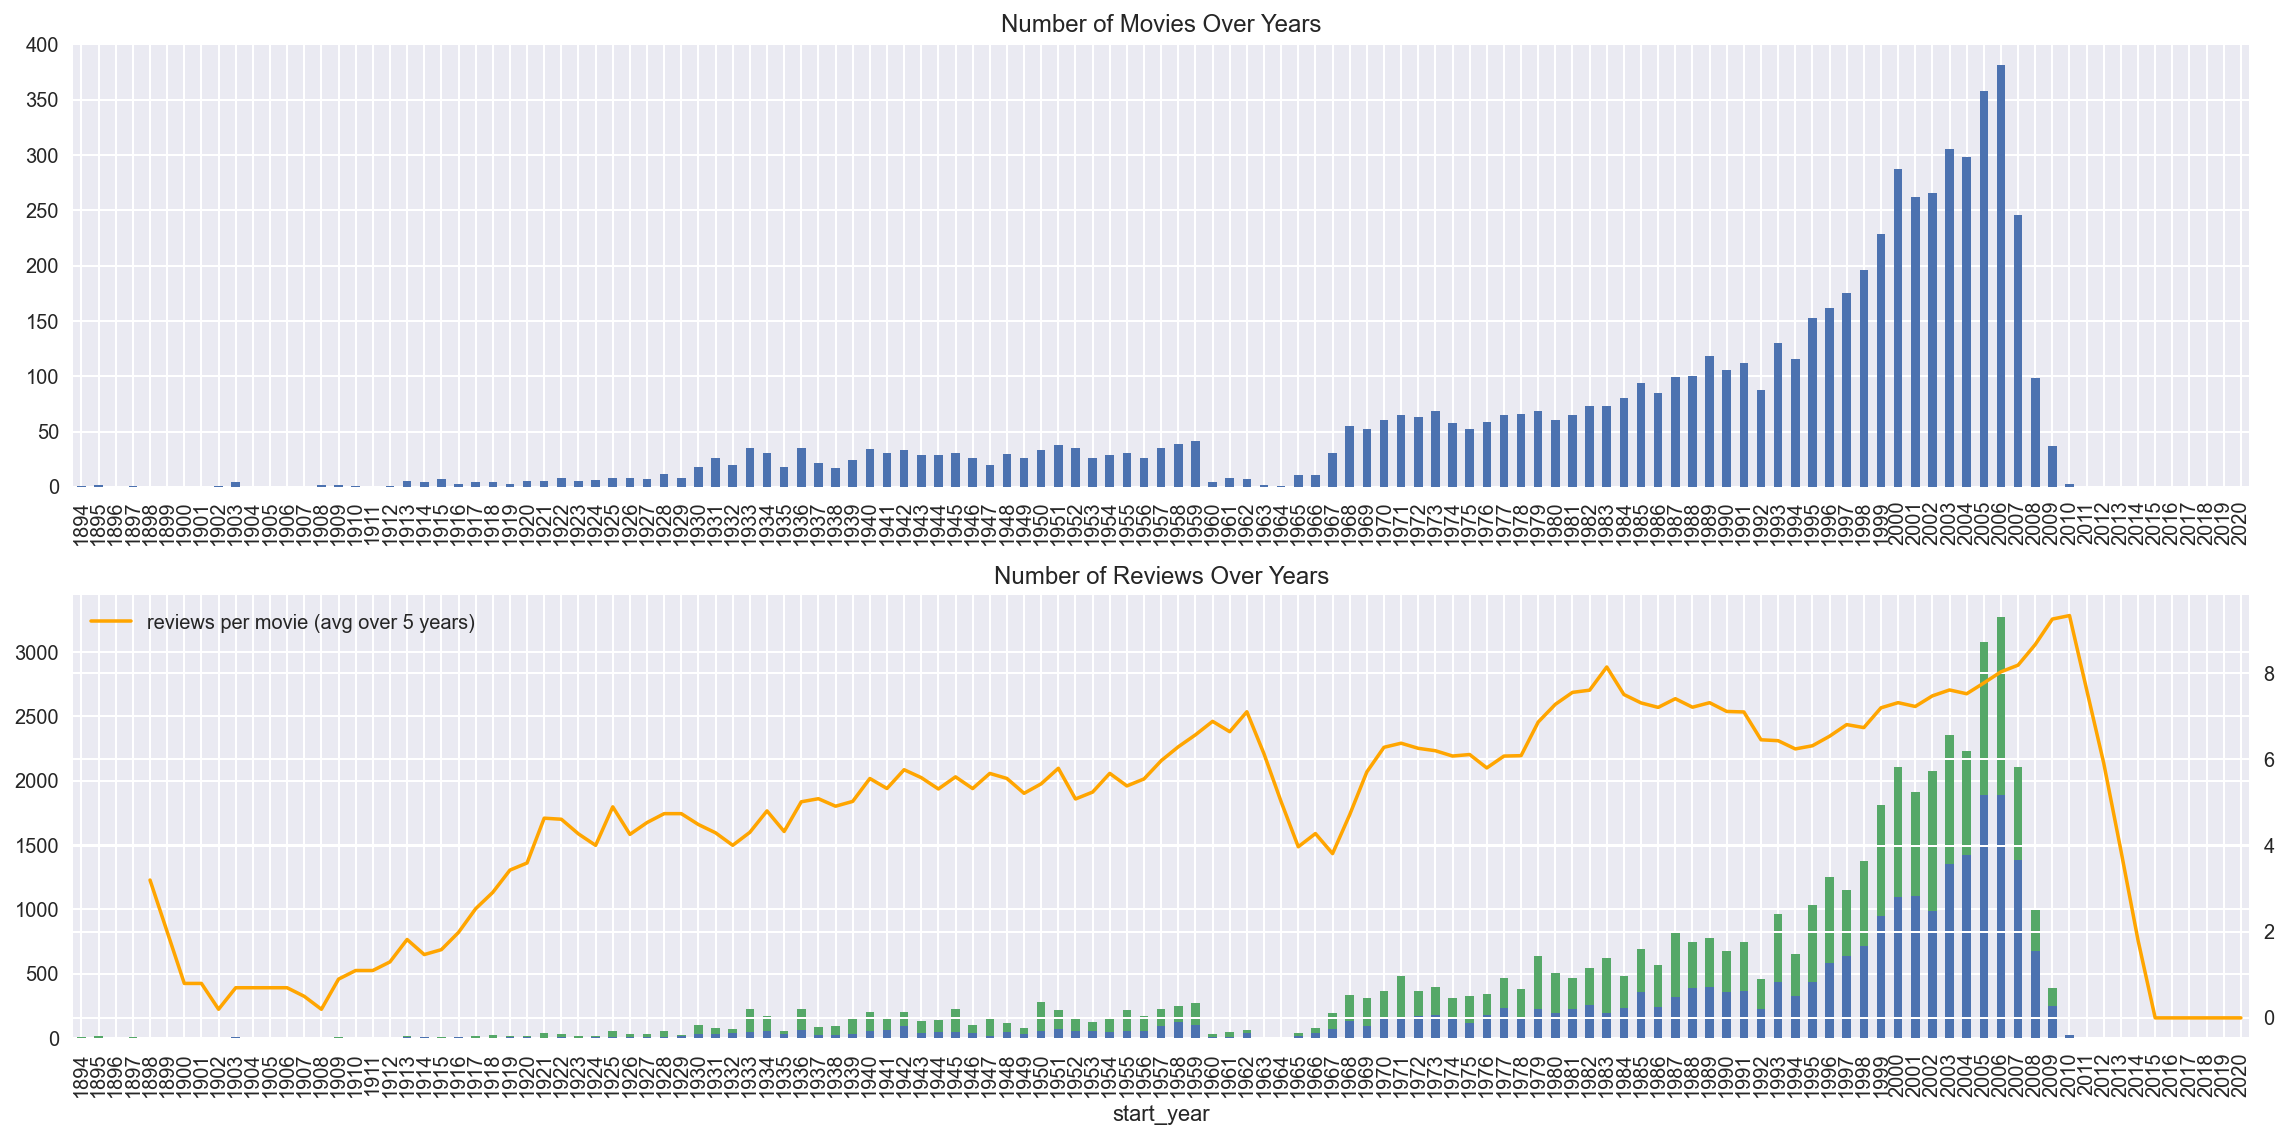

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# get the first axis object
ax = axs[0]

# create the first dataframe and plot it
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

# get the second axis object
ax = axs[1]

# create the second dataframe and plot it
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

# create the third dataframe, plot it, and set the axis labels
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

# get the lines and labels for the legend and set the legend
lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

# set the title of the second axis
ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

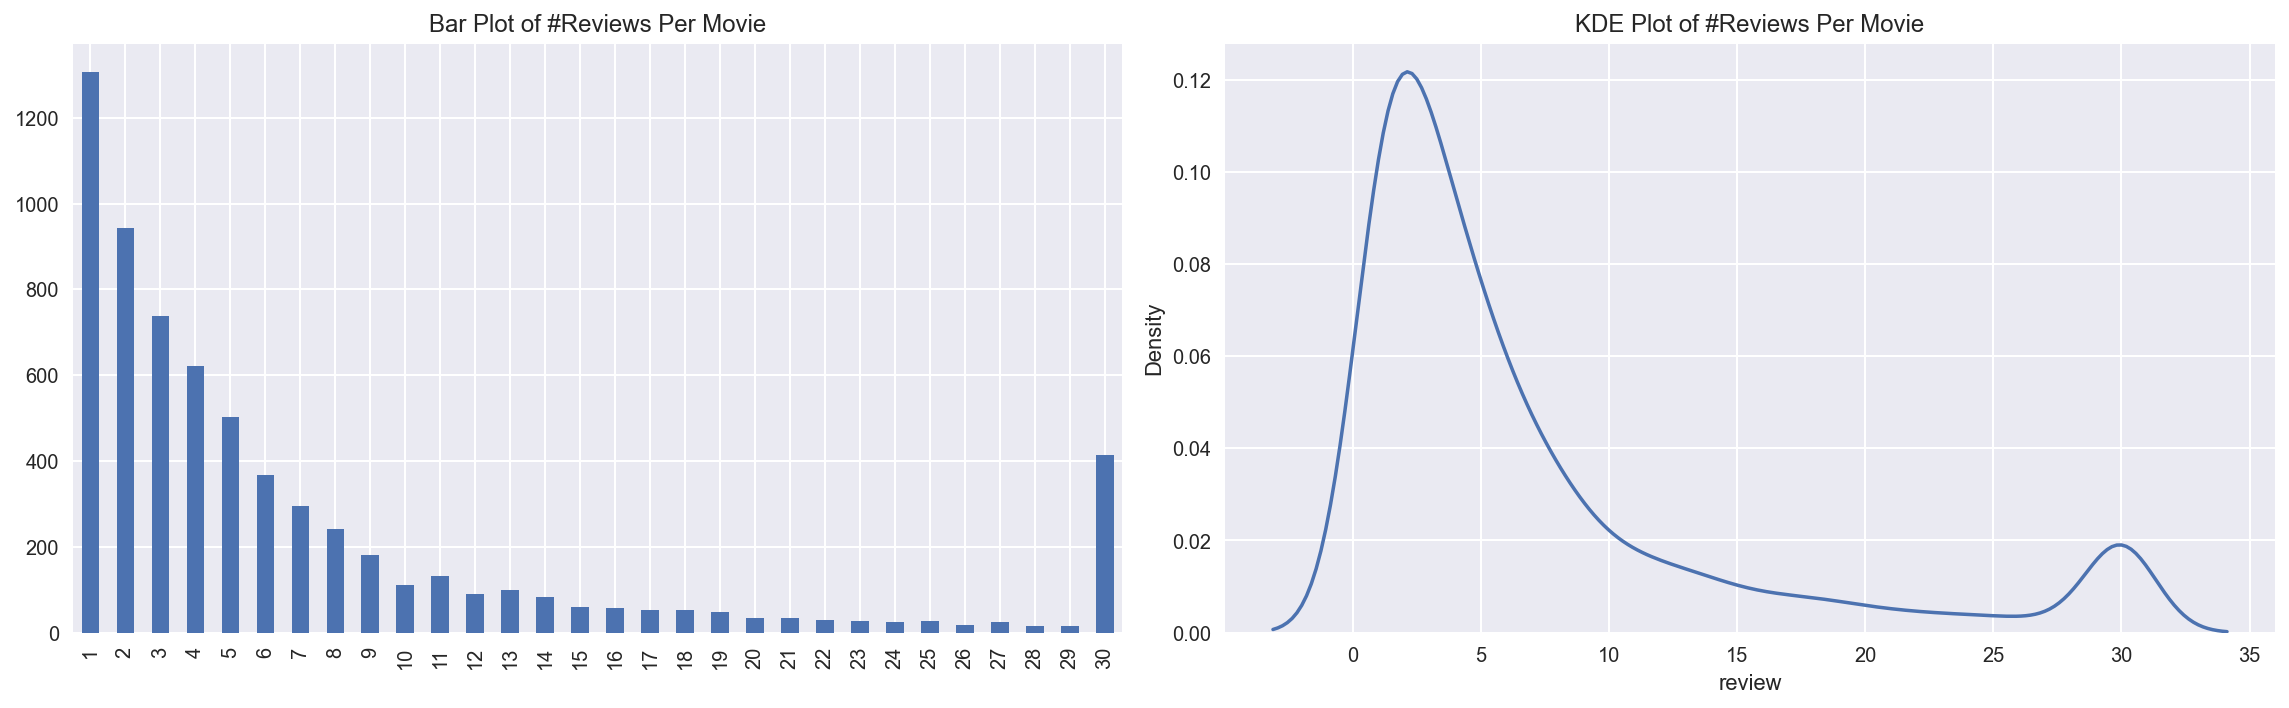

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [9]:
# Look at class imbalance
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

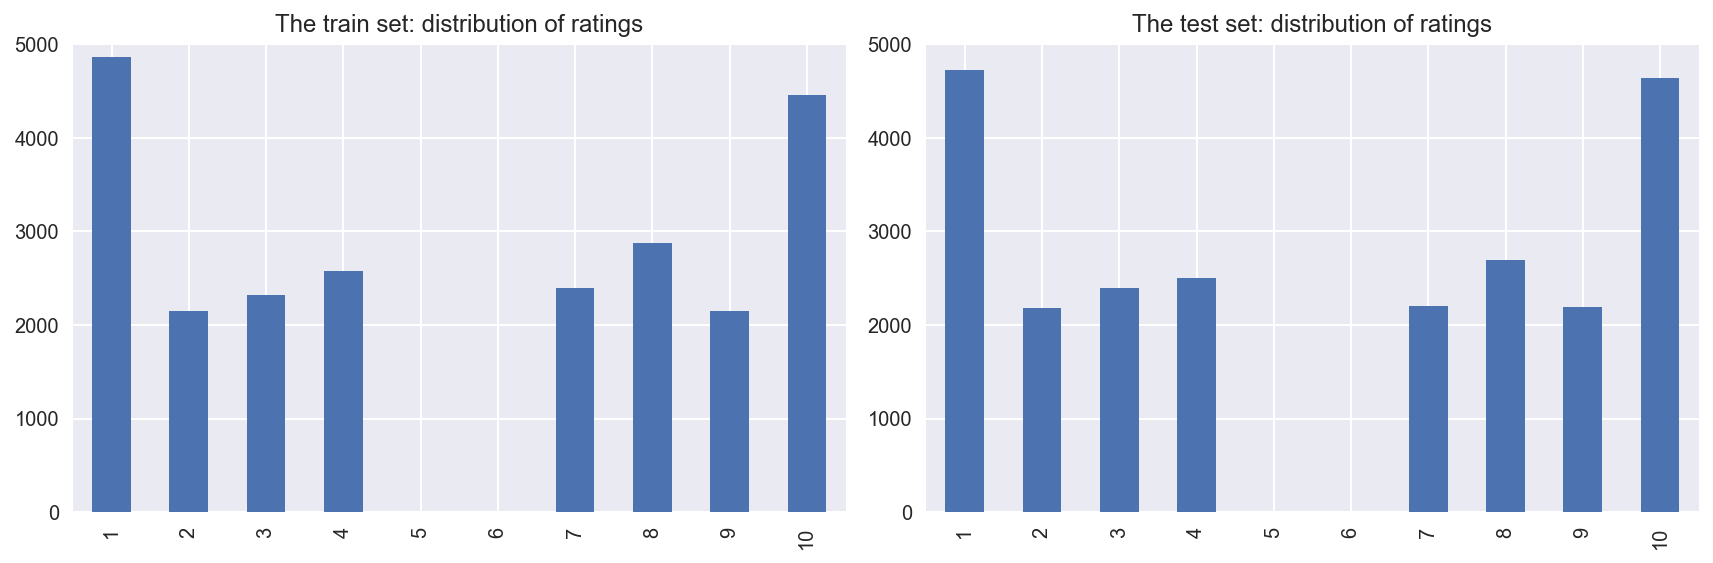

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


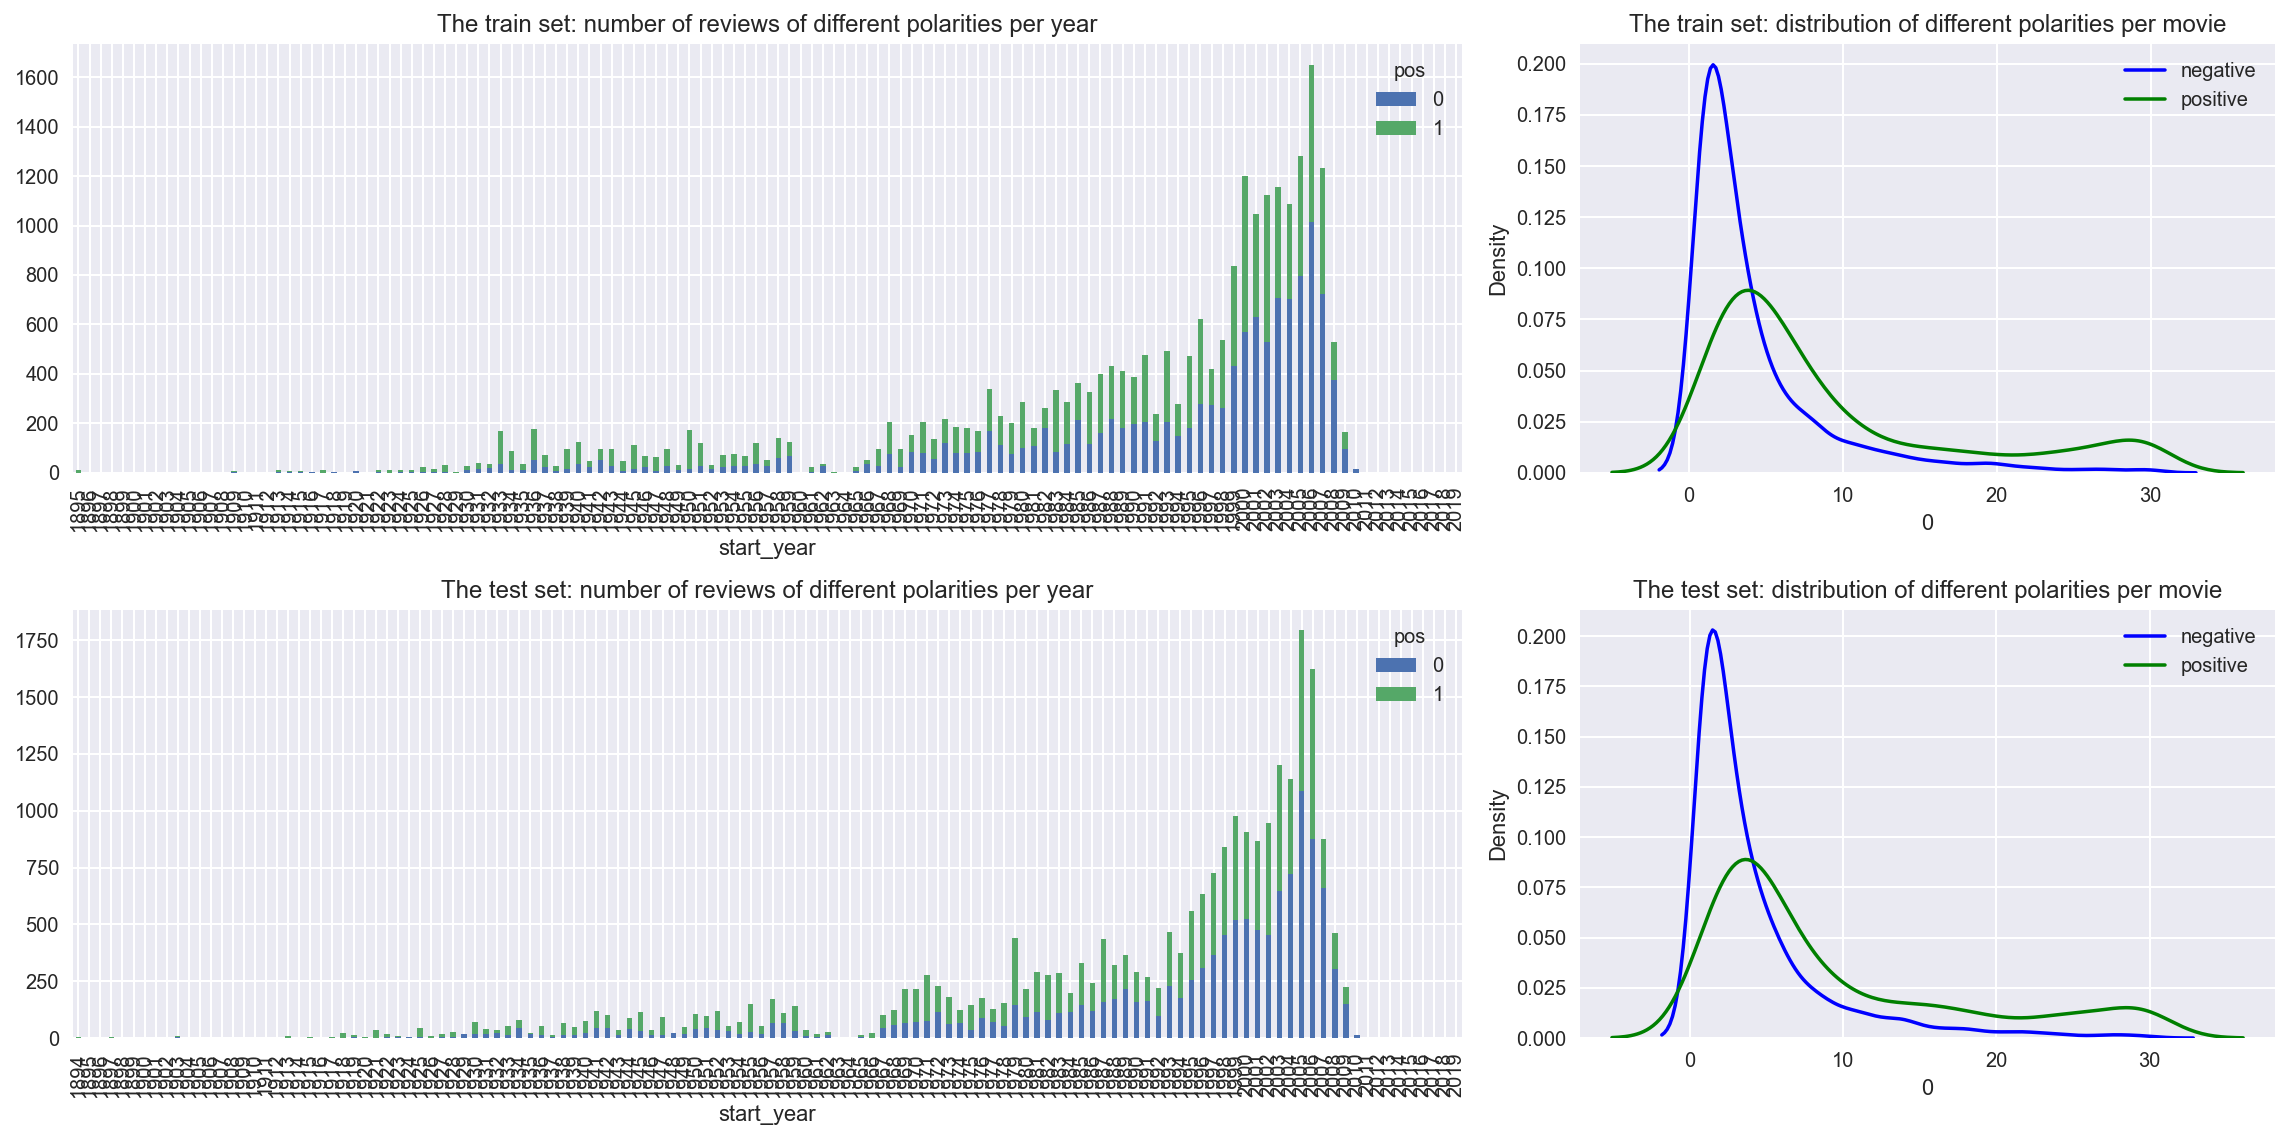

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [5]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

In [6]:
# display info on dataset
df_reviews.info()
display(df_reviews.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [7]:
# change review to lowercase and remove punctuation and numbers
df_reviews['review_norm'] = df_reviews['review'].progress_apply(lambda x: ' '.join(re.sub('[^a-zA-Z]', ' ', x.lower()).split()))

  0%|          | 0/47331 [00:00<?, ?it/s]

In [15]:
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
11168,tt0205896,tvMovie,Dying to Dance,Dying to Dance,2001,\N,96,0,Drama,6.1,320,"Never mind the serious logic gaps, never mind ...",3,neg,0,test,10651,never mind the serious logic gaps never mind t...
19954,tt0407936,tvMovie,Lackawanna Blues,Lackawanna Blues,2005,\N,95,0,"Drama,Music",7.9,2199,"Superb editing, outstanding acting, especially...",8,pos,1,test,58,superb editing outstanding acting especially b...
20186,tt0284253,movie,Lay It Down,Lay It Down,2001,\N,50,0,"Action,Drama,Family",4.7,126,"This is a very ""right on case"" movie that deli...",7,pos,1,test,5747,this is a very right on case movie that delive...
4550,tt0112495,movie,Beyond Rangoon,Beyond Rangoon,1995,\N,100,0,"Action,Adventure,Drama",6.6,4676,This film was sheer boredom from beginning to ...,1,neg,0,test,1085,this film was sheer boredom from beginning to ...
458,tt0472033,movie,9,9,2009,\N,79,0,"Action,Adventure,Animation",7.1,130402,This movie made it into one of my top 10 most ...,1,neg,0,train,6213,this movie made it into one of my top most awf...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [8]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

reviews_norm_train = df_reviews_train['review_norm']
reviews_norm_test = df_reviews_test['review_norm']

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [11]:
dummy = DummyClassifier(random_state=12345).fit(reviews_norm_train, train_target)
prediction_dummy = dummy.predict(reviews_norm_train)
print('Accuracy:', accuracy_score(train_target, prediction_dummy))
print('F1 score:', f1_score(train_target, prediction_dummy))

Accuracy: 0.5005883341738108
F1 score: 0.0


          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


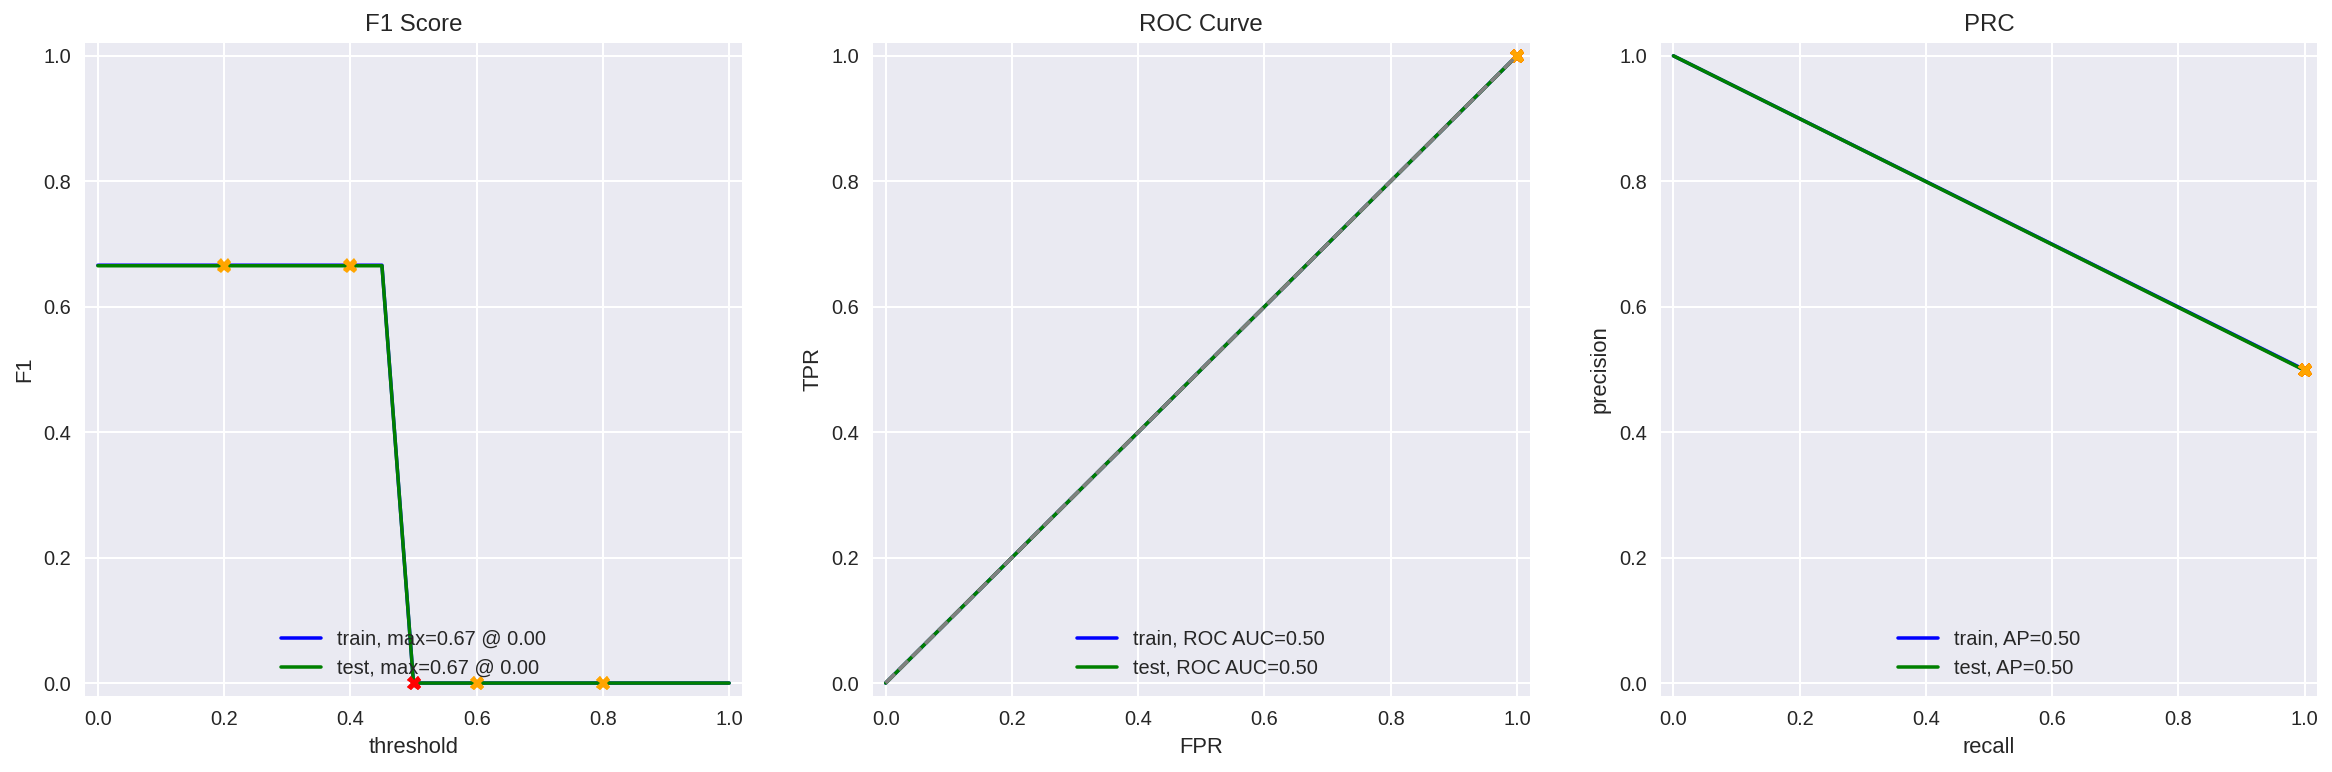

In [12]:
evaluate_model(dummy, prediction_dummy, train_target, dummy.predict(reviews_norm_test), test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [18]:
stop_words = set(stopwords.words('english'))
# create a TfidfVectorizer object with the stop_words set
count_tfidf = TfidfVectorizer(stop_words=stop_words).fit(reviews_norm_train)
# transform the reviews_norm_train list using the TfidfVectorizer object
tf_idf_train = count_tfidf.transform(reviews_norm_train)
print(tf_idf_train.shape)

(23796, 71531)


In [19]:
model_LR = LogisticRegression(random_state=12345).fit(tf_idf_train, train_target)
predictions_LR = model_LR.predict(tf_idf_train)
print('Accuracy:', accuracy_score(train_target, predictions_LR))
print('F1 score:', f1_score(train_target, predictions_LR))

Accuracy: 0.9371322911413683
F1 score: 0.9375886524822695


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


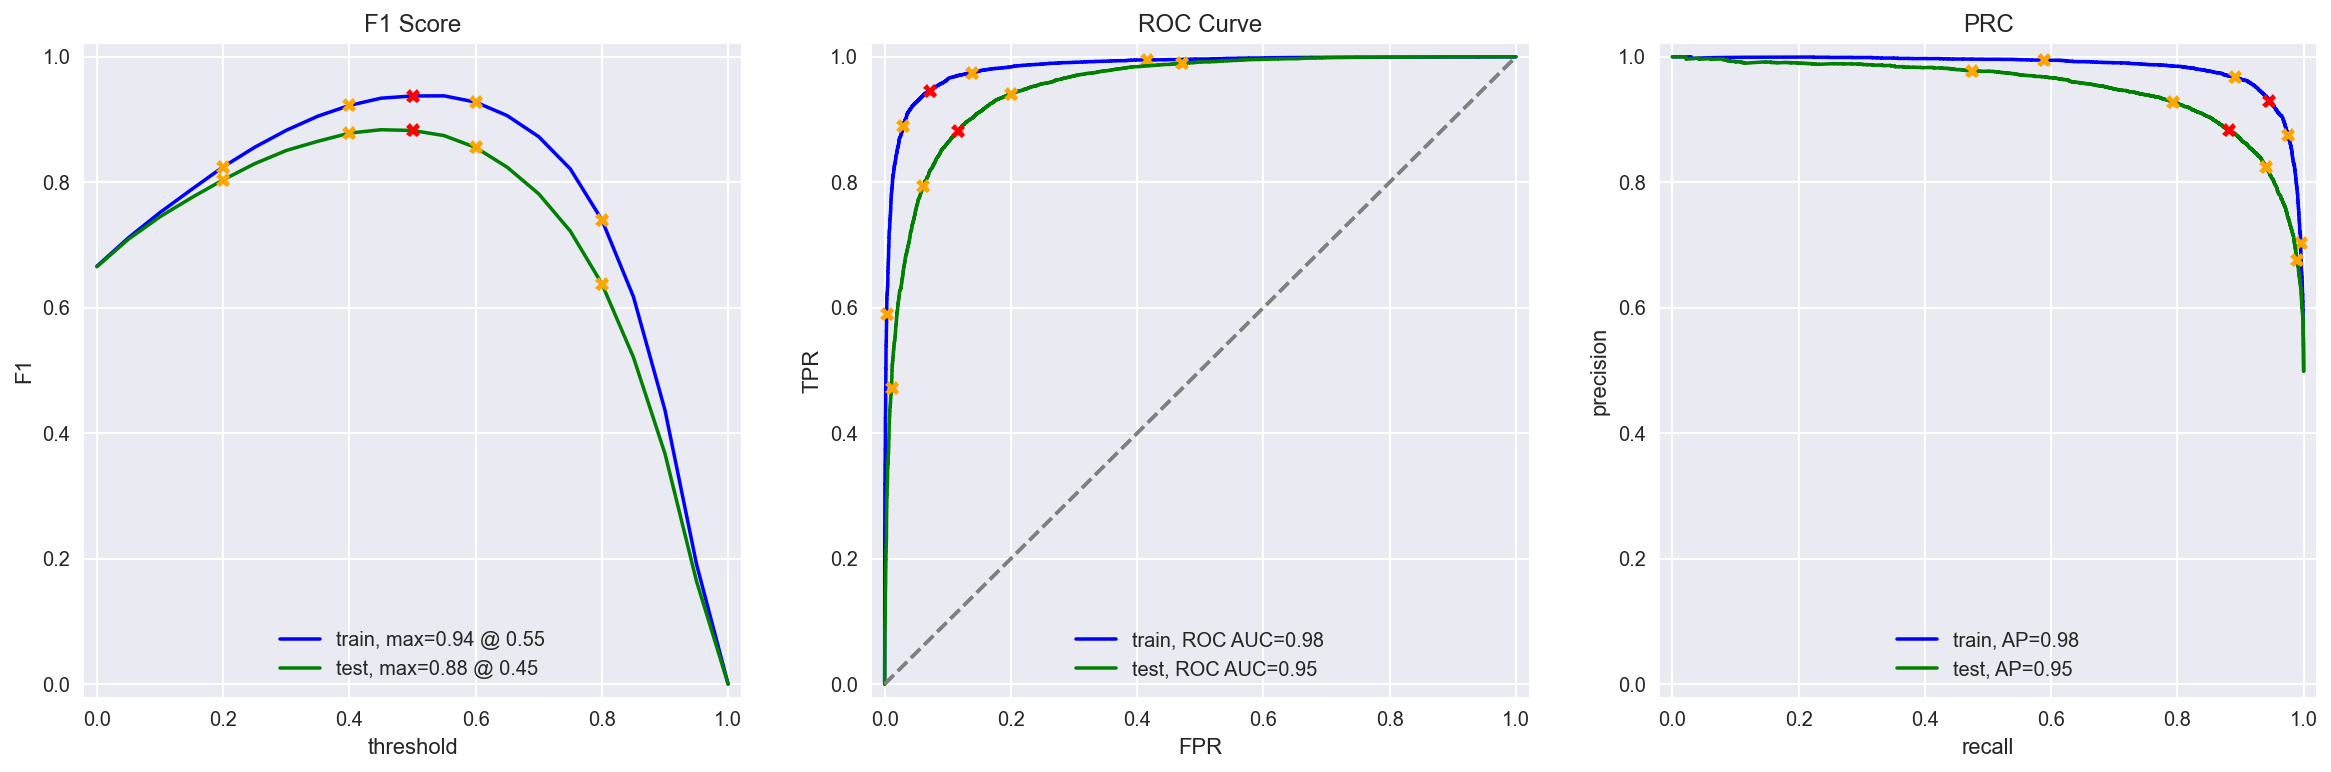

In [20]:
evaluate_model(model_LR, tf_idf_train, train_target, count_tfidf.transform(reviews_norm_test), test_target)

### Model 2 - spaCy, TF-IDF and LR

In [21]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [22]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [23]:
# spacy to lemmatize reviews
reviews_spacy_train = reviews_norm_train.progress_apply(lambda x: text_preprocessing_3(x))

  0%|          | 0/23796 [00:00<?, ?it/s]

In [24]:
count_tfidf_spacy = TfidfVectorizer(stop_words=stop_words).fit(reviews_spacy_train)

tf_idf_spacy_train = count_tfidf_spacy.transform(reviews_spacy_train)
print(tf_idf_spacy_train.shape)

(23796, 59197)


In [25]:
model_LR_spacy = LogisticRegression(random_state=12345).fit(tf_idf_spacy_train, train_target)
predictions_LR_spacy = model_LR_spacy.predict(tf_idf_spacy_train)
print('Accuracy:', accuracy_score(train_target, predictions_LR_spacy))
print('F1 score:', f1_score(train_target, predictions_LR_spacy))

Accuracy: 0.931711211968398
F1 score: 0.932300129150523


In [26]:
reviews_spacy_test = reviews_norm_test.progress_apply(lambda x: text_preprocessing_3(x))

  0%|          | 0/23535 [00:00<?, ?it/s]

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


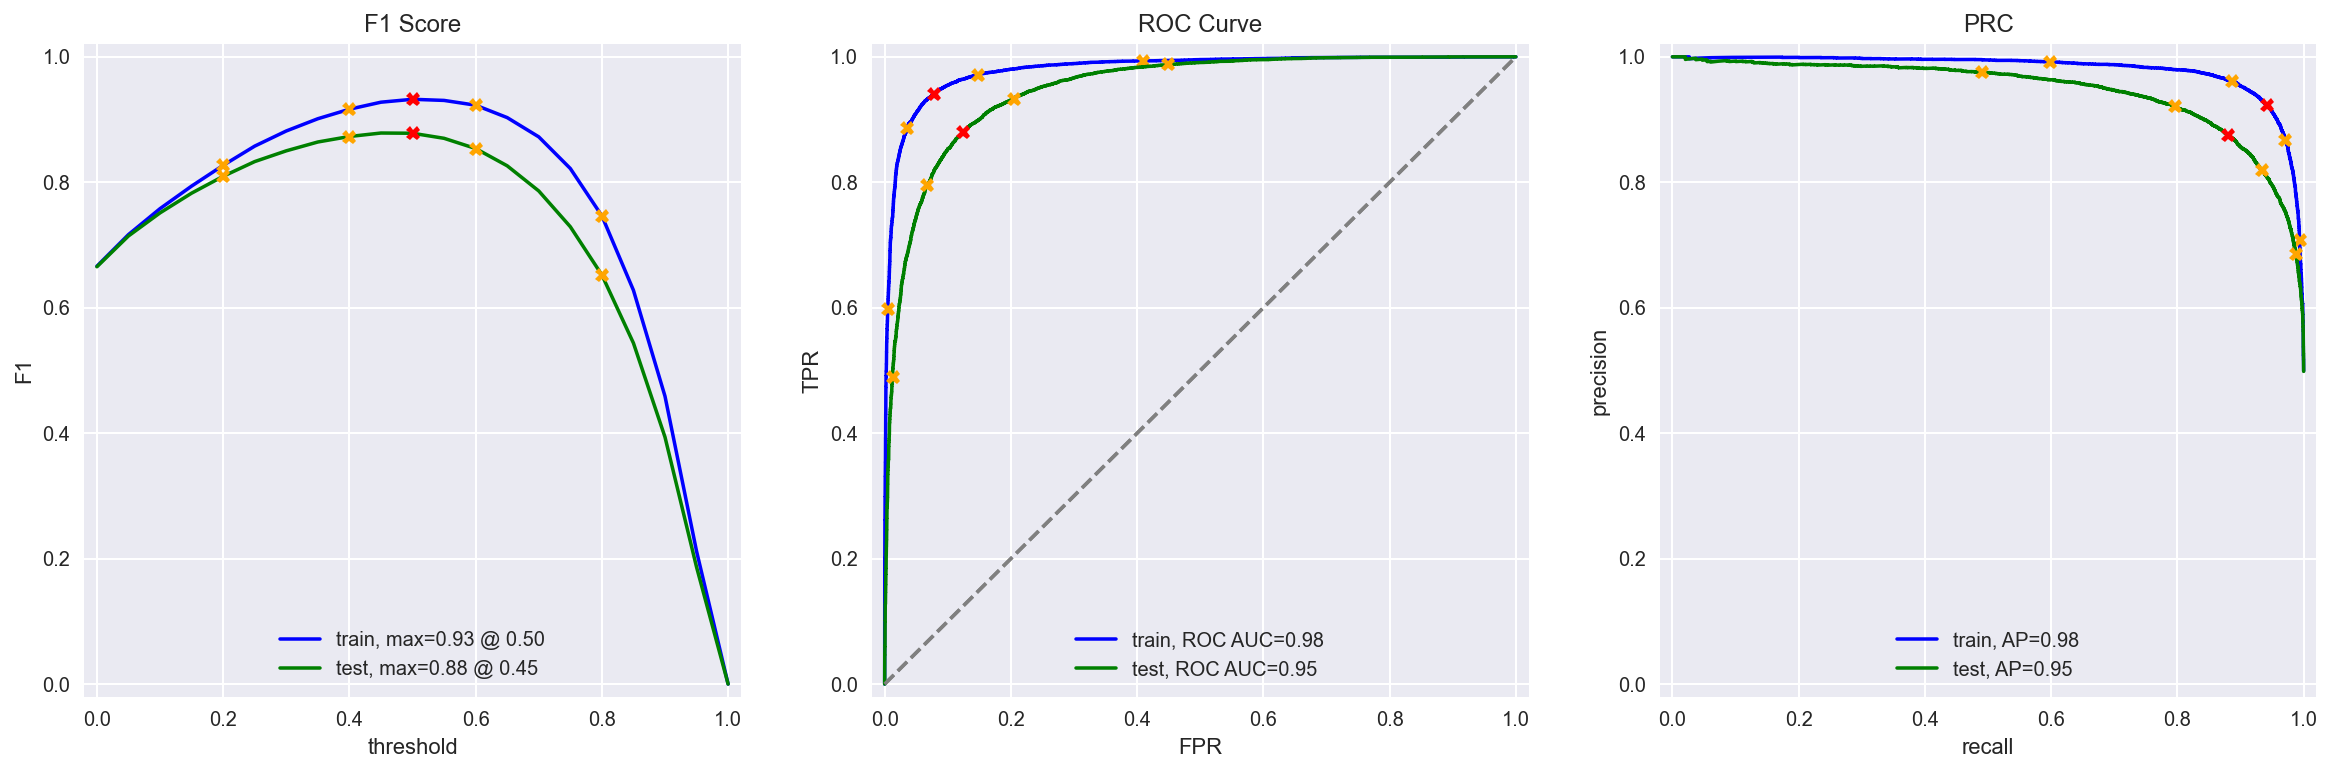

In [27]:
evaluate_model(model_LR_spacy, tf_idf_spacy_train, train_target, count_tfidf_spacy.transform(reviews_spacy_test), test_target)

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [28]:
model_lgb = LGBMClassifier(random_state=12345, n_estimators=200).fit(tf_idf_spacy_train, train_target)
predictions_lgb = model_lgb.predict(tf_idf_spacy_train)
print('Accuracy:', accuracy_score(train_target, predictions_lgb))
print('F1 score:', f1_score(train_target, predictions_lgb))

Accuracy: 0.9574298201378383
F1 score: 0.9576664298549877


          train  test
Accuracy   0.96  0.87
F1         0.96  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


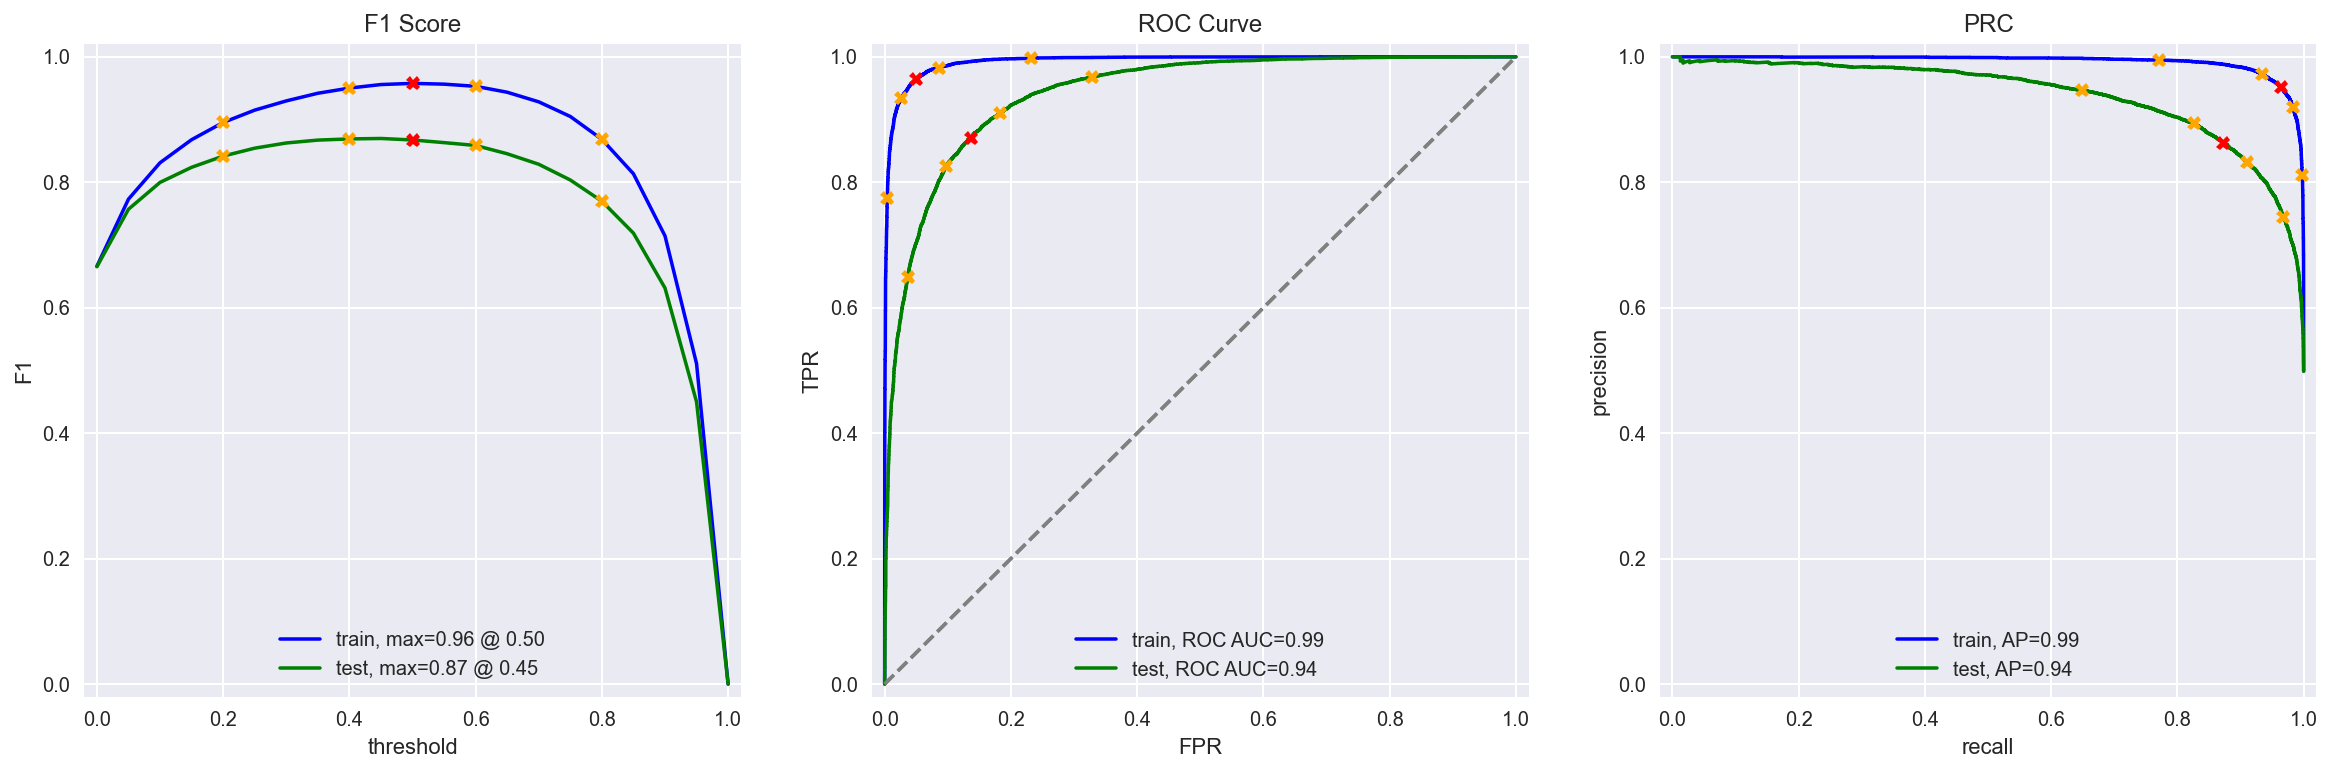

In [29]:
evaluate_model(model_lgb, tf_idf_spacy_train, train_target, count_tfidf_spacy.transform(reviews_spacy_test), test_target)

###  Model 9 - BERT

In [30]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    for input_text in texts:
        ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [32]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(reviews_norm_train.iloc[:200])
#train_features_9 = BERT_text_to_embeddings(reviews_norm_train.iloc[:200], force_device='cuda')

Using the cpu device.


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\uland\AppData\Local\Temp\ipykernel_8348\2446459993.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [33]:
print(reviews_norm_train.iloc[:200].shape)
print(train_features_9.shape)
print(train_target.iloc[:200].shape)

(200,)
(200, 768)
(200,)


In [34]:
test_features_9 = BERT_text_to_embeddings(reviews_norm_test.iloc[:200])

Using the cpu device.


  0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
# Train and test model with logistic regression
model_LR_BERT = LogisticRegression(random_state=12345).fit(train_features_9, train_target.iloc[:200])
predictions_train_BERT = model_LR_BERT.predict(train_features_9)
predictions_test_BERT = model_LR_BERT.predict(test_features_9)
print('Accuracy on train set:', accuracy_score(train_target.iloc[:200], predictions_train_BERT))
print('F1 on train set:', f1_score(train_target.iloc[:200], predictions_train_BERT))
print('Accuracy on test set:', accuracy_score(test_target.iloc[:200], predictions_test_BERT))
print('F1 on test set:', f1_score(test_target.iloc[:200], predictions_test_BERT))

Accuracy on train set: 1.0
F1 on train set: 1.0
Accuracy on test set: 0.795
F1 on test set: 0.7709497206703911


C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Only a list of 200 samples were processed by BERT and trained due to limited computational resources. The accuracy and F1 score on the test set is fairly low, this can be likely significantly improved by increasing the number of samples.

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [36]:
# Testing custom reviews

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'Best movie ever!',
    'I think the director lost their mind',
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].progress_apply(lambda x: ' '.join(re.sub('[^a-zA-Z]', ' ', x.lower()).split()))

my_reviews

  0%|          | 0/10 [00:00<?, ?it/s]

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...
8,Best movie ever!,best movie ever
9,I think the director lost their mind,i think the director lost their mind


### Model 1 - NLTK, TF-IDF, LR

In [37]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_LR.predict_proba(count_tfidf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.96:  best movie ever
0.40:  i think the director lost their mind


### Model 2 - spaCy, TF-IDF, LR

In [38]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_LR_spacy.predict_proba(count_tfidf_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.15:  well i was bored and felt asleep in the middle of the movie
0.47:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didn t expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.89:  best movie ever
0.32:  i think the director lost their mind


### Model 3 - spaCy, TF-IDF, LGBMClassifier

In [39]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_lgb.predict_proba(count_tfidf_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.52:  i did not simply like it not my kind of movie
0.29:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.26:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.48:  i didn t expect the reboot to be so good writers really cared about the source material
0.66:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.17:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.80:  best movie ever
0.49:  i think the director lost their mind


### Model 9 - BERT LR

In [40]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_LR_BERT.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.03:  i did not simply like it not my kind of movie
0.00:  well i was bored and felt asleep in the middle of the movie
0.04:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.00:  i didn t expect the reboot to be so good writers really cared about the source material
0.27:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.67:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.03:  best movie ever
0.00:  i think the director lost their mind


## Conclusions

Various models and methods were tested and trained including using NLTK, spaCy, TF-IDF, and trained on logistric regression, and gradient boosting methods. All of these models achieved a F1 score on the test set of about 0.88, which meets our target metric.

I would note that improvements can be made here to tune hyperparameters, as there appears to be some overfitting of the data. For example, using LGBMClassifier, the F1 score on the train set is 0.96, while the test set is 0.87. Further parameter tuning could improve overall metrics.

BERT was used but only for a small set of data (200 rows) due to its heavy computational requirements. Further evaluation can be performed by increasing the number of samples for training.